<a href="https://colab.research.google.com/github/beatlesatani/OCR_project/blob/main/Japanese_handwritten_text_detection_horizontal_vertical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

【Binarization】


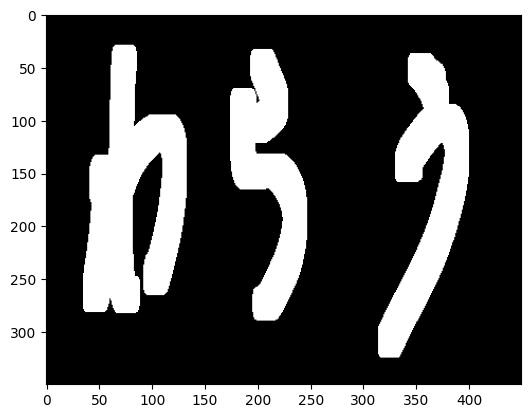


【Text detection・Contours】


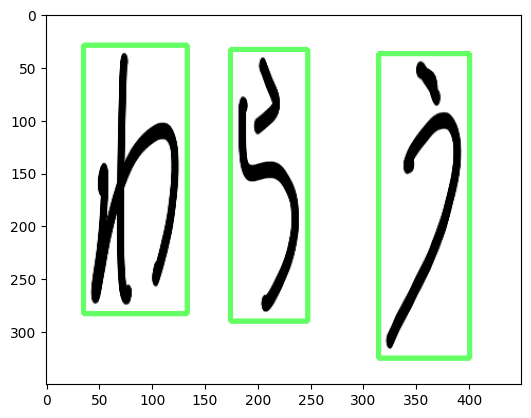

In [104]:

#### 1.import ####

import os
import cv2
import numpy as np
from imutils import contours
import matplotlib.pyplot as plt
import glob
from natsort import natsorted # ファイルを自然順（0,1,2,3,・・,20,21,・・30,31,・・）に並べるために「natsort」を利用

from google.colab import drive
drive.mount('/content/gdrive')

#### ２．set up pictures ####
input_file = "/content/gdrive/MyDrive/pictures/laugh.png"

#### 3.setting ####
horizontal = 0
OCR_mode = 0


# 膨張処理の設定
#【横書き】大まかな文字領域の検出（ブロック検出）のための膨張処理（カーネルサイズ・膨張処理回数）の設定
block_horizontal_kernel_hight = 5  # カーネルの縦の高さ
block_horizontal_kernel_width = 5  # カーネルの横の幅
block_horizontal_iterations = 4    # 膨張処理回数


#【横書き】行領域の検出（行検出）のための膨張処理（カーネルサイズ・膨張処理回数）の設定
column_horizontal_kernel_hight = 2  # カーネルの縦の高さ
column_horizontal_kernel_width = 5  # カーネルの横の幅
column_horizontal_iterations = 6    # 膨張処理回数


#【横書き】個別の文字の検出（文字検出）のための膨張処理（カーネルサイズ・膨張処理回数）の設定
character_horizontal_kernel_hight = 5  # カーネルの縦の高さ 5
character_horizontal_kernel_width = 3  # カーネルの横の幅 3
character_horizontal_iterations = 3    # 膨張処理回数


# 輪郭のカット設定
# ブロック検出：文字領域検出した輪郭の「横幅」が、以下の範囲なら輪郭を残す
block_horizontal_height_minimum = 5  # 最小値（ピクセル）
block_horizontal_height_max = 1000   # 最大値（ピクセル）

# ブロック検出：文字領域検出した輪郭の「縦の高さ」が、以下の範囲なら輪郭を残す
block_vertical_height_minimum = 5  # 最小値（ピクセル）
block_vertical_height_max = 1000   # 最大値（ピクセル）


# 行検出：文字領域検出した輪郭の「横幅」が、以下の範囲なら輪郭を残す
row_column_horizontal_height_minimum = 5  # 最小値（ピクセル）
row_column_horizontal_height_max = 1000   # 最大値（ピクセル）

# 列検出：文字領域検出した輪郭の「縦の高さ」が、以下の範囲なら輪郭を残す
row_column_vertical_height_minimum = 5  # 最小値（ピクセル）
row_column_vertical_height_max = 1000   # 最大値（ピクセル）


# 個別の文字領域検出した輪郭の「横幅」が、以下の範囲なら輪郭を残す
character_text_detection_horizontal_height_minimum = 10  # 最小値（ピクセル）
character_text_detection_horizontal_height_max = 200    # 最大値（ピクセル）

# 個別の文字領域検出した輪郭の「縦の高さ」が、以下の範囲なら輪郭を残す
character_text_detection_vertical_height_minimum = 10  # 最小値（ピクセル）
character_text_detection_vertical_height_max = 200     # 最大値（ピクセル）





####  ４．大まかな文字領域の検出（ブロック検出） ####
# 画像から、ブロック検出をおこないます
# 「block_ROI_img〜.png」（ブロック検出画像）を作成します
# 「block_text-detection.png」（ブロック検出の結果を、元の画像に描画した画像）を作成します


# Process for detecting and extracting character regions from images
def block_contours (OCR_input_file):
  img = cv2.imread(OCR_input_file)
  width = 450
  height = 350
  img = cv2.resize(img, (width, height))

  # convert image to monochrome gray picture
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # convert to monochrome image
  retval, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # 白部分の膨張処理（Dilation）：モルフォロジー変換 - 2値画像を対象
  if OCR_mode == 0:
    kernel = np.ones((block_horizontal_kernel_hight, block_horizontal_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    img_dilation = cv2.dilate(img_binary,kernel,iterations = block_horizontal_iterations)
  elif OCR_mode == 1: #
    kernel = np.ones((block_vertical_kernel_hight, block_vertical_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    img_dilation = cv2.dilate(img_binary,kernel,iterations = block_vertical_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定

  print('\n【Binarization】')

  # 膨張処理後の2値化画像の表示
  plt.imshow(cv2.cvtColor(img_dilation, cv2.COLOR_BGR2RGB))
  plt.show()


  # detect contour
  #cnts: coordinates of contour,  hierarchy: how to detect contour
  #cv2.RETR_EXTERNAL：return the most external contour.
  #cv2.CHAIN_APPROX_SIMPLE : do not contain all pointns on the contour to reduce data size.leaves only their end points.
  cnts, hierarchy = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if OCR_mode == 0:
    cnts, hierarchy = contours.sort_contours(cnts, method='left-to-right')
  elif OCR_mode == 1:
    cnts, hierarchy = contours.sort_contours(cnts, method='right-to-left')

  # first setting of ROI
  block_ROI_index = 0

  # convert contour coordinates to the list
  result = []
  for contour in cnts:
    x, y, w, h = cv2.boundingRect(contour)
    # remove too large area / too small area
    if not block_vertical_height_minimum < w < block_vertical_height_max:
      continue
    if not block_horizontal_height_minimum < h < block_horizontal_height_max:
      continue

    # extract ROI
    block_ROI = img[y:y+h, x:x+w]
    # 保存する画像のフォルダーのパスを指定
    output_folder = 'ROI_images'

    # フォルダーが存在しない場合は作成
    if not os.path.exists(output_folder):
      os.mkdir(output_folder)
    cv2.imwrite('block_ROI_img{}.png'.format(block_ROI_index), block_ROI)
    block_ROI_index += 1

    result.append([x, y, w, h])


  # 画面に矩形の輪郭を描画 （描画機能）
  for x, y, w, h in result:
      cv2.rectangle(img, (x, y), (x+w, y+h), (100, 255, 100), 3)


  # 解説用のコメント（文字領域の輪郭検出・抽出）
  if OCR_mode == 0:
    print('\n【Text detection・Contours】')
  elif OCR_mode == 1:
    print('\n【Text detection・Contours】')

  # 文字領域の輪郭検出・抽出結果の表示
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.savefig('block_text-detection.png', dpi=300)
  plt.show()



## 大まかな文字領域の検出（ブロック検出）の関数（block_contours）の実行
block_contours (input_file)



# New Section

In [105]:
'''
import glob
import os


# 大まかな文字領域の検出（ブロック検出）した画像（「block_ROI_img〜.png」）の削除
file_list = glob.glob("block_ROI_img*png")
for file in file_list:
  os.remove(file)


# 横書き・縦書きの行・列領域の検出（行と列の検出）した画像（「row_column_ROI_img〜.png」）の削除
file_list = glob.glob('row_column_ROI_img*png')
for file in file_list:
  os.remove(file)


# 個別の文字の検出（文字検出）画像（「OCR_img〜.png」）の削除
file_list = glob.glob('OCR_img*png')
for file in file_list:
  os.remove(file)
'''

'\nimport glob\nimport os\n\n\n# 大まかな文字領域の検出（ブロック検出）した画像（「block_ROI_img〜.png」）の削除\nfile_list = glob.glob("block_ROI_img*png")\nfor file in file_list:\n  os.remove(file)\n\n\n# 横書き・縦書きの行・列領域の検出（行と列の検出）した画像（「row_column_ROI_img〜.png」）の削除\nfile_list = glob.glob(\'row_column_ROI_img*png\')\nfor file in file_list:\n  os.remove(file)\n\n\n# 個別の文字の検出（文字検出）画像（「OCR_img〜.png」）の削除\nfile_list = glob.glob(\'OCR_img*png\')\nfor file in file_list:\n  os.remove(file)\n'

In [106]:
from tensorflow.keras.models import load_model
model = load_model("/content/gdrive/MyDrive/hiragana_recognition_cnn.h5")
image_width = 32  # ここを変更。使用する学習済みモデルと同じwidth（横幅）を指定
image_height = 32 # ここを変更。使用する学習済みモデルと同じheight（縦の高さ）を指定

error: ignored

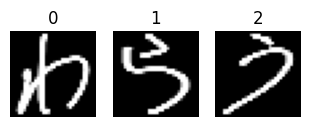

In [107]:
#### ８．画像判定のためのプログラム ####
folder = ['あ','い','う','え','お',
              'か','き','く','け','こ',
              'さ','し','す','せ','そ',
              'た','ち','つ','て','と',
              'な','に','ぬ','ね','の',
              'は','ひ','ふ','へ','ほ',
              'ま','み','む','め','も',
              'や','ゆ','よ',
              'ら','り','る','れ','ろ',
              'わ','を','ん']


import cv2
import matplotlib.pyplot as plt

def invert_monochrome_colors(image):
    if image is not None:
        inverted_image = 255 - image
        return inverted_image
    else:
        print("Failed to load the image.")
        return None

# List to store the processed images
result = []

# Loop through the image files
for i, image_file in enumerate(image_files):
    # Load the image using OpenCV
    img = cv2.imread(image_file)

    # Convert the image to grayscale and resize it to 32x32
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (32, 32))

    # Invert the colors of the processed image
    img_inverted = invert_monochrome_colors(img_resized)

    # Append the label (i) and the processed image to the result list
    result.append([i, img_inverted])

    # Display the first 5 images
    if i < 5:
        plt.subplot(1, 5, i + 1)
        plt.axis("off")
        plt.title(str(i))
        plt.imshow(img_inverted, cmap='gray')

# Show the plotted images
plt.show()





In [108]:
for item in result:
    index, image = item
    shape = image.shape
    #print(f"Index {index}: Shape {shape}, Dimensions: {image.ndim}")
result

[[0,
  array([[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,   0, 101, ...,   0,   0,   0],
         [  0,   0,  11, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
 [1,
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
 [2,
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 4, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]]

In [ ]:
one_image = result[0]
one_image = one_image[1]
one_image.shape
#need to add brightness values

In [ ]:
im_size = 32
im_color = 1
in_shape = (im_size, im_size, im_color)

new_image = []
for d in result:
  (num, img) = d
  img = img.astype('float').reshape(im_size, im_size, im_color) / 255
  new_image.append(img)
new_image = np.array(new_image)

In [ ]:
new_image[0][10]

In [ ]:
new_image.shape

In [ ]:
predicted = model.predict(new_image)

In [ ]:
import pandas as pd

In [99]:
predictions = np.argmax(predicted, axis=1)
pd.DataFrame(predictions)

,0
0,44
1,43
2,10
3,44


In [100]:
predictions

array([44, 43, 10, 44])

In [91]:
len(folder)

46

In [92]:
corresponding_labels = [folder[i] for i in predictions]

print(corresponding_labels)

['を', 'わ', 'さ', 'を']


In [94]:
#毎回写真を消す
file_list = glob.glob("block_ROI_img*png")
for file in file_list:
  os.remove(file)